In [1]:
import sys
import os
import time
import numpy as np
import dolfin as dl

import pickle

import torch

from scipy.interpolate import griddata

src_path = "../../../src/"
sys.path.append(src_path + 'plotting')
from field_plot import field_plot, field_plot_grid, quick_field_plot, quick_field_plot_grid
from plot_mix_collection import *
from point_plot import *

sys.path.append(src_path + 'data/')
from dataMethods import DataProcessor

sys.path.append(src_path + 'nn/deeponet/')
sys.path.append(src_path + 'nn/mlp/') # need this here so that DeepONet can be imported (it imports MLP)
from load_data_and_deeponet import load_data_and_deeponet

sys.path.append(src_path + 'nn/pcanet/')
from load_data_and_pcanet import load_data_and_pcanet

sys.path.append(src_path + 'nn/fno/')
from load_data_and_fno import load_data_and_fno

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
from mpl_toolkits.axes_grid1 import ImageGrid

# set seed
seed = 0
np.random.seed(seed)

In [4]:
data_folder = 'data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/' + data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Load neural operators

In [3]:
def load_deeponet():
    data_path = data_folder + 'Poisson_samples.npz'
    nn_path = 'DeepONet/Results/model.pkl'
    data, nn = load_data_and_deeponet(data_path, nn_path)
    print('nn_data: ', data)
    print('nn_model: ', nn)

    return data, nn

deeponet_data, deeponet = load_deeponet()

nn_data:  <dataMethods.DataProcessor object at 0x70b1cda1cd10>
nn_model:  DeepONet(
  (branch_net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2601, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=100, bias=True)
    )
  )
  (trunk_net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=100, bias=True)
    )
  )
)


In [4]:
def load_pcanet():
    data_path = data_folder + 'Poisson_samples.npz'
    nn_path = 'PCANet/Results/model.pkl'
    data, nn = load_data_and_pcanet(data_path, nn_path)
    print('nn_data: ', data)
    print('nn_model: ', nn)

    return data, nn

pcanet_data, pcanet = load_pcanet()

nn_data:  <dataMethods.DataProcessor object at 0x70b3c80a5ed0>
nn_model:  PCANet(
  (net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=100, out_features=250, bias=True)
      (1-2): 2 x Linear(in_features=250, out_features=250, bias=True)
      (3): Linear(in_features=250, out_features=100, bias=True)
    )
  )
)


In [5]:
def load_fno():
    data_path = data_folder + 'Poisson_FNO_samples.npz'
    nn_path = 'FNO/Results/model.pkl'
    data, nn = load_data_and_fno(data_path, nn_path)
    print('nn_data: ', data)
    print('nn_model: ', nn)

    return data, nn

fno_data, fno = load_fno()

nn_data:  <dataMethods.DataProcessorFNO object at 0x70b1bbd16490>
nn_model:  FNO2D(
  (fno_layers): ModuleList(
    (0-2): 3 x FNO2DLayer(
      (w): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (input_projector): Linear(in_features=3, out_features=20, bias=True)
  (output_projector): Linear(in_features=20, out_features=1, bias=True)
)


# Evaluate the models on testing data

In [6]:
deeponet_test_data = {'X_train': deeponet_data.X_test, 'X_trunk': deeponet_data.X_trunk, 'Y_train': deeponet_data.Y_test}

pcanet_test_data = {'X_train': pcanet_data.X_test, 'Y_train': pcanet_data.Y_test}

fno_test_data = {'X_train': fno_data.X_test, 'Y_train': fno_data.Y_test}

In [7]:
# DeepONet predictions
deeponet_Y_test_pred = deeponet.predict(deeponet_data.X_test, deeponet_data.X_trunk).detach().numpy()

deeponet_Y_test_error = np.linalg.norm(deeponet_data.Y_test - deeponet_Y_test_pred, axis = 1)/np.linalg.norm(deeponet_data.Y_test, axis = 1)

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(len(deeponet_data.Y_test), np.mean(deeponet_Y_test_error), np.std(deeponet_Y_test_error)))

Num tests:  1000, Mean Loss (rel l2): 1.402e-01, Std Loss (rel l2): 4.970e-02


In [8]:
# PCANet predictions
pcanet_Y_test_pred = pcanet.predict(pcanet_data.X_test).detach().numpy()

pcanet_Y_test_error = np.linalg.norm(pcanet_data.Y_test - pcanet_Y_test_pred, axis = 1)/np.linalg.norm(pcanet_data.Y_test, axis = 1)

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(len(pcanet_data.Y_test), np.mean(pcanet_Y_test_error), np.std(pcanet_Y_test_error)))

Num tests:  1000, Mean Loss (rel l2): 1.051e-01, Std Loss (rel l2): 3.714e-02


In [9]:
# FNO predictions
fno_Y_test_pred = fno.predict(fno_data.X_test).detach().numpy()

a = fno_data.Y_test.reshape(fno_data.Y_test.shape[0], -1)
b = fno_Y_test_pred.reshape(fno_Y_test_pred.shape[0], -1)

fno_Y_test_error = np.linalg.norm(a - b, axis = 1)/np.linalg.norm(a, axis = 1)

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(len(a), np.mean(fno_Y_test_error), np.std(fno_Y_test_error)))

Num tests:  1000, Mean Loss (rel l2): 6.779e-02, Std Loss (rel l2): 2.098e-02


## Plotting

In [10]:
def apply_dirichlet_bc(u, bc_value, bc_node_ids):
    u[bc_node_ids] = bc_value
    return u

def apply_grid_dirichlet_bc(u, bc_value, bc_node_ids):
    u[bc_node_ids[:, 0], bc_node_ids[:,1]] = bc_value
    return u

In [5]:
i_choices = [27, 47, 43, 80,  5] #, 46, 14, 66,  2, 79]

In [13]:
plot_dir = 'compare_nops/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)


nodes = deeponet_data.X_trunk
grid_x, grid_y = fno_data.grid_x_test[0], fno_data.grid_y_test[0]
cmaps = ['jet', 'jet', 'hot']

plt.ioff()
for i in i_choices:
    print('i = ', i)
    
    print('  save m')
    i_m = deeponet_data.decoder_X(deeponet_data.X_test[i])
   
    quick_field_plot(i_m, nodes, cmap = cmaps[0], \
                     savefilename = 'compare_nops/m_{}.png'.format(i), show_plot = False)
    plt.close()

    print('  save true u')
    i_u = deeponet_data.decoder_Y(deeponet_data.Y_test[i])
    quick_field_plot(i_u, nodes, cmap = cmaps[1], \
                     savefilename = 'compare_nops/u_{}.png'.format(i), show_plot = False)
    plt.close()

    print('  save DeepONet u')
    i_u_deeponet = deeponet_data.decoder_Y(deeponet_Y_test_pred[i])
    apply_dirichlet_bc(i_u_deeponet, 0, deeponet_data.u_mesh_dirichlet_boundary_nodes)
    quick_field_plot(i_u_deeponet, nodes, cmap = cmaps[1], \
                     savefilename = 'compare_nops/u_deeponet_{}.png'.format(i), show_plot = False)
    plt.close()

    print('  save DeepONet error')
    i_u_deeponet_error = i_u - i_u_deeponet
    quick_field_plot(i_u_deeponet_error, nodes, cmap = cmaps[2], \
                     savefilename = 'compare_nops/u_deeponet_error_{}.png'.format(i), show_plot = False)
    plt.close()

    i_u_deeponet_error_norm = np.linalg.norm(i_u - i_u_deeponet)/np.linalg.norm(i_u)    
    np.savetxt('compare_nops/u_deeponet_error_norm_{}.txt'.format(i), np.array([i_u_deeponet_error_norm]))

    print('  save PCANet u')
    i_u_pcanet = pcanet_data.decoder_Y(pcanet_Y_test_pred[i])
    apply_dirichlet_bc(i_u_pcanet, 0, pcanet_data.u_mesh_dirichlet_boundary_nodes)
    quick_field_plot(i_u_pcanet, nodes, cmap = cmaps[1], \
                     savefilename = 'compare_nops/u_pcanet_{}.png'.format(i), show_plot = False)
    plt.close()

    print('  save PCANet error')
    i_u_pcanet_error = i_u - i_u_pcanet
    quick_field_plot(i_u_pcanet_error, nodes, cmap = cmaps[2], \
                     savefilename = 'compare_nops/u_pcanet_error_{}.png'.format(i), show_plot = False)
    plt.close()
    
    i_u_pcanet_error_norm = np.linalg.norm(i_u - i_u_pcanet)/np.linalg.norm(i_u)
    np.savetxt('compare_nops/u_pcanet_error_norm_{}.txt'.format(i), np.array([i_u_pcanet_error_norm]))

    print('  save FNO u')
    i_u_grid = fno_data.decoder_Y(fno_data.Y_test[i])[:, :, 0]
    i_u_fno = fno_data.decoder_Y(fno_Y_test_pred[i])[:, :, 0]
    apply_grid_dirichlet_bc(i_u_fno, 0, fno_data.u_grid_dirichlet_boundary_nodes)
    quick_field_plot_grid(i_u_fno, grid_x, grid_y, cmap = cmaps[1], \
                     savefilename = 'compare_nops/u_fno_{}.png'.format(i), show_plot = False)
    plt.close()

    print('  save FNO error')
    i_u_fno_error = i_u_grid - i_u_fno
    quick_field_plot_grid(i_u_fno_error, grid_x, grid_y, cmap = cmaps[2], \
                     savefilename = 'compare_nops/u_fno_error_{}.png'.format(i), show_plot = False)
    plt.close()

    i_u_fno_error_norm = np.linalg.norm(i_u_grid - i_u_fno)/np.linalg.norm(i_u_grid)
    np.savetxt('compare_nops/u_fno_error_norm_{}.txt'.format(i), np.array([i_u_fno_error_norm]))





i =  27
  save m
  save true u
  save DeepONet u
  save DeepONet error
  save PCANet u
  save PCANet error
  save FNO u
  save FNO error
i =  47
  save m
  save true u
  save DeepONet u
  save DeepONet error
  save PCANet u
  save PCANet error
  save FNO u
  save FNO error
i =  43
  save m
  save true u
  save DeepONet u
  save DeepONet error
  save PCANet u
  save PCANet error
  save FNO u
  save FNO error
i =  80
  save m
  save true u
  save DeepONet u
  save DeepONet error
  save PCANet u
  save PCANet error
  save FNO u
  save FNO error
i =  5
  save m
  save true u
  save DeepONet u
  save DeepONet error
  save PCANet u
  save PCANet error
  save FNO u
  save FNO error


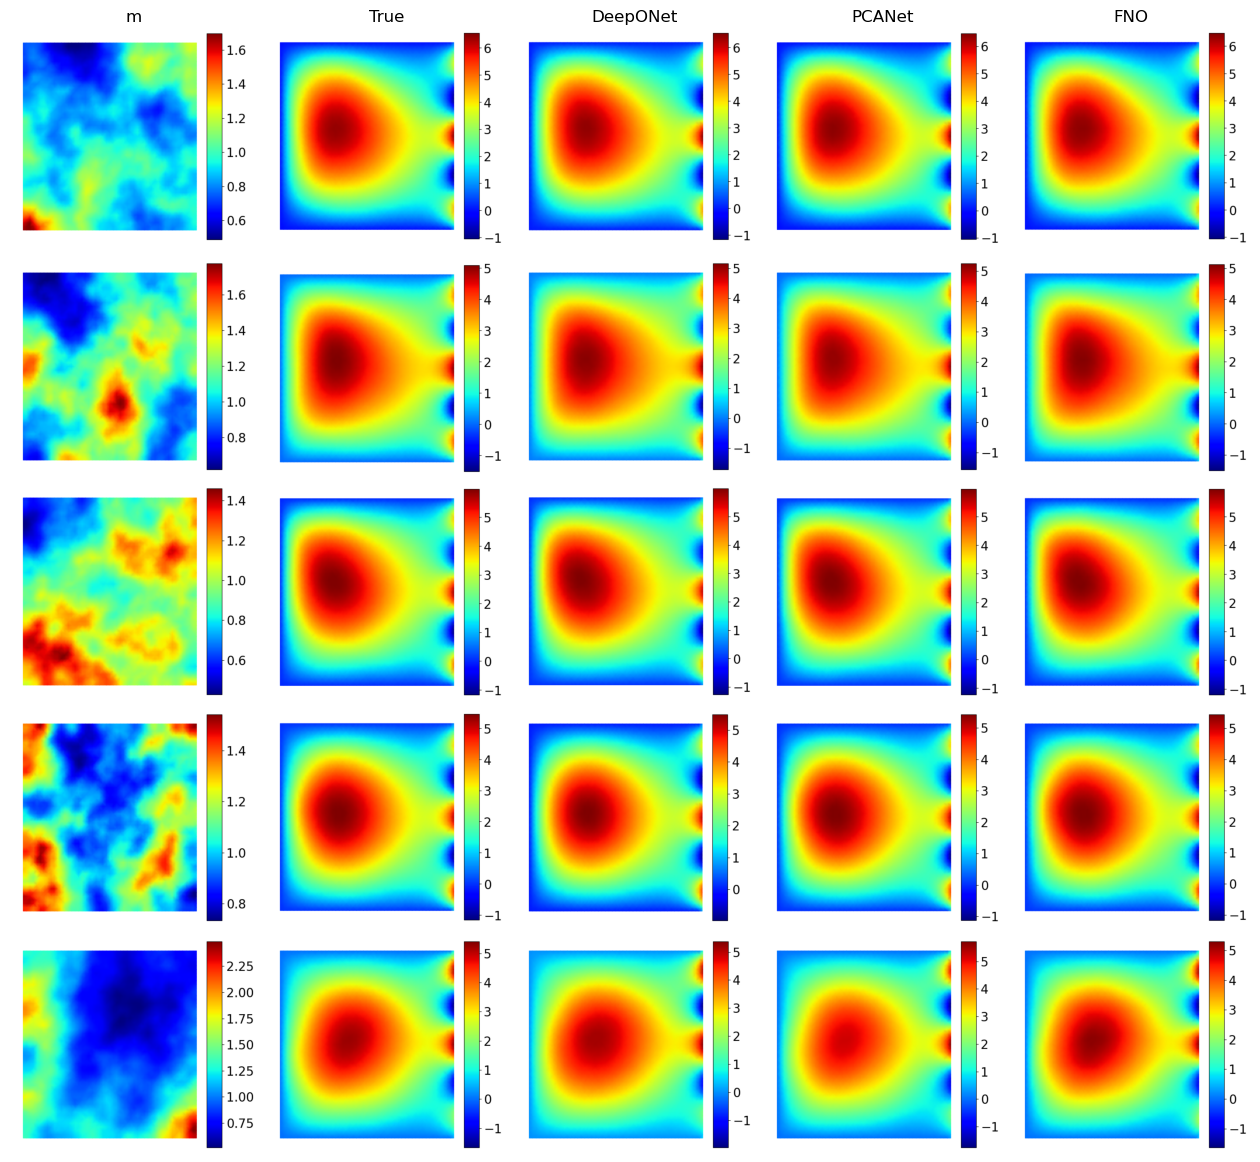

In [13]:
# plot the results


fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(len(i_choices), 5),
                 axes_pad=0.1,
                 )

imgs = []
for i in range(len(i_choices)):
    imgs.append(plt.imread('compare_nops/m_{}.png'.format(i_choices[i])))
    imgs.append(plt.imread('compare_nops/u_{}.png'.format(i_choices[i])))
    imgs.append(plt.imread('compare_nops/u_deeponet_{}.png'.format(i_choices[i])))
    imgs.append(plt.imread('compare_nops/u_pcanet_{}.png'.format(i_choices[i])))
    imgs.append(plt.imread('compare_nops/u_fno_{}.png'.format(i_choices[i])))

counter = 0
lbls = ['m', 'True', 'DeepONet', 'PCANet', 'FNO']
for ax, im in zip(grid, imgs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis('off')
    if counter < len(i_choices):
        ax.set_title(lbls[counter%5])
    counter += 1

    

plt.show()